## [Graph Data Science Python Driver](https://github.com/neo4j/graph-data-science-client)

In [1]:
#!pip install graphdatascience

## Imports

In [2]:
# Data
import pandas as pd
from graphdatascience import GraphDataScience

# Viz
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay

## Setup

In [3]:
URI      = "neo4j://localhost:7687"
creds    = ('neo4j', 'password123')
gds      = GraphDataScience(URI, auth=creds)

## Load CORA Data
#### Data from https://github.com/CJ2001

![](https://cdn-images-1.medium.com/fit/t/1600/480/1*oygeCjtUsS87duvFoDT8tA.png)

### Create Constraint

In [4]:
c = '''
// Create constraints
CREATE CONSTRAINT papers IF NOT EXISTS FOR (p:Paper) REQUIRE p.id IS UNIQUE;
'''

gds.run_cypher(c)

""


### Import Nodes

In [5]:
c = '''
// Load node list
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_nodes.csv' AS line
WITH line
MERGE (p:Paper {id: line.id})
    ON CREATE SET p.subject = line.subject, p.features = line.features
RETURN COUNT(*)
'''

gds.run_cypher(c)

,COUNT(*)
0,2708


### Import Edges

In [6]:
c = '''
// Load edge list
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_edges.csv' AS line
WITH line
MATCH (source:Paper {id: line.source})
MATCH (target:Paper {id: line.target})
MERGE (source)-[:CITES]->(target)
RETURN COUNT(*)
'''

gds.run_cypher(c)

,COUNT(*)
0,5429


## Create graph projection

In [7]:
node_projection = ["Paper"]
relationship_projection = {"CITES": 
                           {"orientation": "UNDIRECTED"}
                          }
    
try:
    G = gds.graph.get("papers")
    
except ValueError:
    G, _ = gds.graph.project("papers", 
                             node_projection, 
                             relationship_projection)

In [8]:
def projection_stats(G):
    print('name:', G.name(), '\n')
    print('degree_distribution:\n', G.degree_distribution())
    print('density:', G.density(), '\n')
    print('node_count:', G.node_count())
    print('relationship_count:', G.relationship_count()) 

## EDA

In [9]:
projection_stats(G)

name: papers 

degree_distribution:
 p99      19.000000
min       1.000000
max     169.000000
p90       7.000000
mean      4.009601
p999     74.000000
p50       3.000000
p95       9.000000
p75       5.000000
dtype: float64
density: 0.0014811973334628368 

node_count: 2708
relationship_count: 10858


In [10]:
gds.wcc.stream(G).componentId.nunique()

78

## Stream FastRP Embeddings

In [11]:
# Run FastRP and mutate projection with result
result = gds.fastRP.stream(
    G,
    embeddingDimension=64,
    iterationWeights=[0.8, 1, 1, 1],
)

result.head()

,nodeId,embedding
0,261,"[0.5860615968704224, 1.040419578552246, -0.066..."
1,4310,"[0.03969547525048256, -0.5061486959457397, 0.3..."
2,4311,"[0.33045971393585205, 0.7313153147697449, -0.4..."
3,4312,"[0.04990717023611069, 0.6742268204689026, -0.2..."
4,4313,"[0.04384936764836311, 0.1841091811656952, 0.10..."


### Clean up Dataframe with Pandas transforms

In [12]:
df = pd.concat([result[['nodeId']],
                   pd.DataFrame.from_dict(dict(zip(result.embedding.index, result.embedding.values))).T],
                axis=1)
df.head()

,nodeId,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,261,0.586062,1.040420,-0.066483,0.786419,0.689556,-0.152191,0.175381,0.166393,0.015046,...,0.408778,-0.572783,-0.314005,-0.106203,0.046320,-0.298478,0.594408,-0.240220,-0.173066,-1.104837
1,4310,0.039695,-0.506149,0.373270,0.237211,0.075377,0.663281,-0.656109,0.161535,-0.154647,...,0.094400,0.099447,0.088621,0.141390,-0.131408,0.776987,0.667386,0.071565,0.023596,0.742791
2,4311,0.330460,0.731315,-0.489831,0.292264,-0.084341,0.114764,0.471716,0.257089,0.333911,...,0.197670,0.109472,-0.210545,-0.213780,-0.291939,-0.451464,-0.156348,0.143799,-0.276446,-0.686953
3,4312,0.049907,0.674227,-0.223448,0.030393,-0.432023,-0.722068,0.430771,-0.123524,-0.011800,...,-0.007022,-0.040112,-0.171295,0.265440,-0.071577,-0.197787,-0.374375,0.306024,-0.232441,-0.088726
4,4313,0.043849,0.184109,0.106030,-0.440090,0.571709,-0.347157,0.036479,-0.321659,0.072390,...,0.071876,-0.028305,-0.438033,-0.344523,-0.426573,0.158731,0.047179,0.049112,0.085672,0.770713


In [13]:
df = pd.merge(gds.run_cypher('MATCH (n:Paper) RETURN id(n) as nodeId, n.subject as class'),
                df,
              on="nodeId")
df.head()

,nodeId,class,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
0,261,Neural_Networks,0.586062,1.040420,-0.066483,0.786419,0.689556,-0.152191,0.175381,0.166393,...,0.408778,-0.572783,-0.314005,-0.106203,0.046320,-0.298478,0.594408,-0.240220,-0.173066,-1.104837
1,4310,Rule_Learning,0.039695,-0.506149,0.373270,0.237211,0.075377,0.663281,-0.656109,0.161535,...,0.094400,0.099447,0.088621,0.141390,-0.131408,0.776987,0.667386,0.071565,0.023596,0.742791
2,4311,Reinforcement_Learning,0.330460,0.731315,-0.489831,0.292264,-0.084341,0.114764,0.471716,0.257089,...,0.197670,0.109472,-0.210545,-0.213780,-0.291939,-0.451464,-0.156348,0.143799,-0.276446,-0.686953
3,4312,Reinforcement_Learning,0.049907,0.674227,-0.223448,0.030393,-0.432023,-0.722068,0.430771,-0.123524,...,-0.007022,-0.040112,-0.171295,0.265440,-0.071577,-0.197787,-0.374375,0.306024,-0.232441,-0.088726
4,4313,Probabilistic_Methods,0.043849,0.184109,0.106030,-0.440090,0.571709,-0.347157,0.036479,-0.321659,...,0.071876,-0.028305,-0.438033,-0.344523,-0.426573,0.158731,0.047179,0.049112,0.085672,0.770713


## Loop over desired algorithms and add them to Dataframe

In [14]:
for algo in ['pageRank', 'betweenness']:
    method = getattr(gds, algo)
    
    df = pd.merge(df, 
                    method.stream(G).rename(columns={'score': algo}),
                  on="nodeId")
df.head()

,nodeId,class,0,1,2,3,4,5,6,7,...,56,57,58,59,60,61,62,63,pageRank,betweenness
0,261,Neural_Networks,0.586062,1.040420,-0.066483,0.786419,0.689556,-0.152191,0.175381,0.166393,...,-0.314005,-0.106203,0.046320,-0.298478,0.594408,-0.240220,-0.173066,-1.104837,0.971196,0.500000
1,4310,Rule_Learning,0.039695,-0.506149,0.373270,0.237211,0.075377,0.663281,-0.656109,0.161535,...,0.088621,0.141390,-0.131408,0.776987,0.667386,0.071565,0.023596,0.742791,0.318668,0.000000
2,4311,Reinforcement_Learning,0.330460,0.731315,-0.489831,0.292264,-0.084341,0.114764,0.471716,0.257089,...,-0.210545,-0.213780,-0.291939,-0.451464,-0.156348,0.143799,-0.276446,-0.686953,0.749227,742.050666
3,4312,Reinforcement_Learning,0.049907,0.674227,-0.223448,0.030393,-0.432023,-0.722068,0.430771,-0.123524,...,-0.171295,0.265440,-0.071577,-0.197787,-0.374375,0.306024,-0.232441,-0.088726,0.632337,101.481038
4,4313,Probabilistic_Methods,0.043849,0.184109,0.106030,-0.440090,0.571709,-0.347157,0.036479,-0.321659,...,-0.438033,-0.344523,-0.426573,0.158731,0.047179,0.049112,0.085672,0.770713,0.442147,0.000000


## Create Pandas Plot

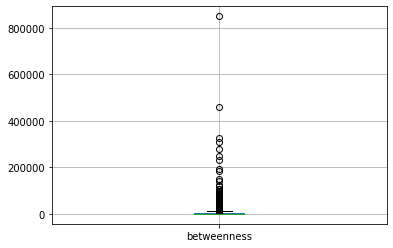

In [15]:
boxplot = df.boxplot(column=['betweenness'])  

In [16]:
df.sort_values(by='betweenness', ascending=False).head()

,nodeId,class,0,1,2,3,4,5,6,7,...,56,57,58,59,60,61,62,63,pageRank,betweenness
163,4472,Genetic_Algorithms,1.009056,0.312882,-0.842211,-0.167950,0.281936,0.372955,-0.020506,-0.206473,...,0.479847,-0.466376,-0.000084,0.296551,0.075004,0.280171,0.094364,0.353691,31.154227,850663.008464
427,4736,Neural_Networks,0.317696,0.453020,0.210641,0.105814,-0.181410,-0.334560,-0.132804,-0.408489,...,0.179870,0.236038,0.008801,0.110824,0.609995,-0.240906,-0.354048,0.185481,13.529566,460317.981318
74,4383,Probabilistic_Methods,0.458662,0.283137,-0.181232,-0.109606,0.575060,0.122657,0.686413,-0.190348,...,0.411005,-0.117496,-0.145901,0.127217,0.446682,-1.010642,0.022176,0.187893,8.049612,324663.039514
747,5056,Neural_Networks,0.627472,0.050579,0.092281,0.474158,-0.061952,-0.548193,-0.664009,-0.278339,...,0.766191,-0.135750,-0.155939,0.758486,-0.143808,-0.635955,-0.285414,0.606804,15.866854,310252.684689
565,4874,Reinforcement_Learning,0.181664,0.773544,-0.293119,0.328961,-0.340909,0.020177,-0.045832,0.354485,...,-0.015825,-0.255166,-0.117887,-0.369899,-0.279372,0.154789,-0.397617,-0.817440,13.014040,278922.368055


## Create Seaborn Plot

<Axes: xlabel='pageRank', ylabel='Count'>

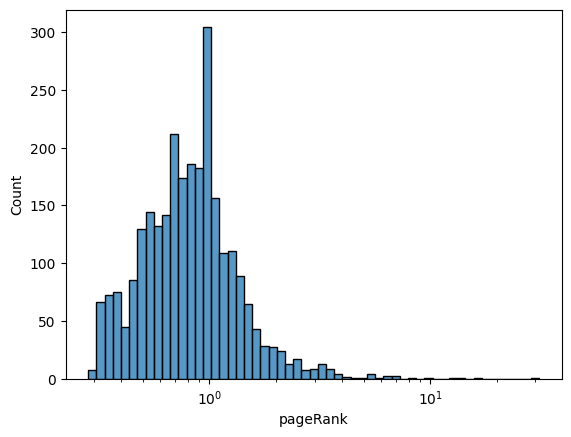

In [17]:
sns.histplot(df.pageRank, log_scale=True)

## Visualize FastRP embeddings with TSNE plot

In [18]:
def create_tsne_plot(df):

    X_emb = TSNE(n_components=2).fit_transform(df[df.columns[2:-3]])

    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb], 
        'label': pd.factorize(df['class'])[0].astype("float32")
    })

    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls', 7),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=100,
        alpha=0.75
    )
    ax.legend(prop={'size': 10})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show

/opt/anaconda3/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


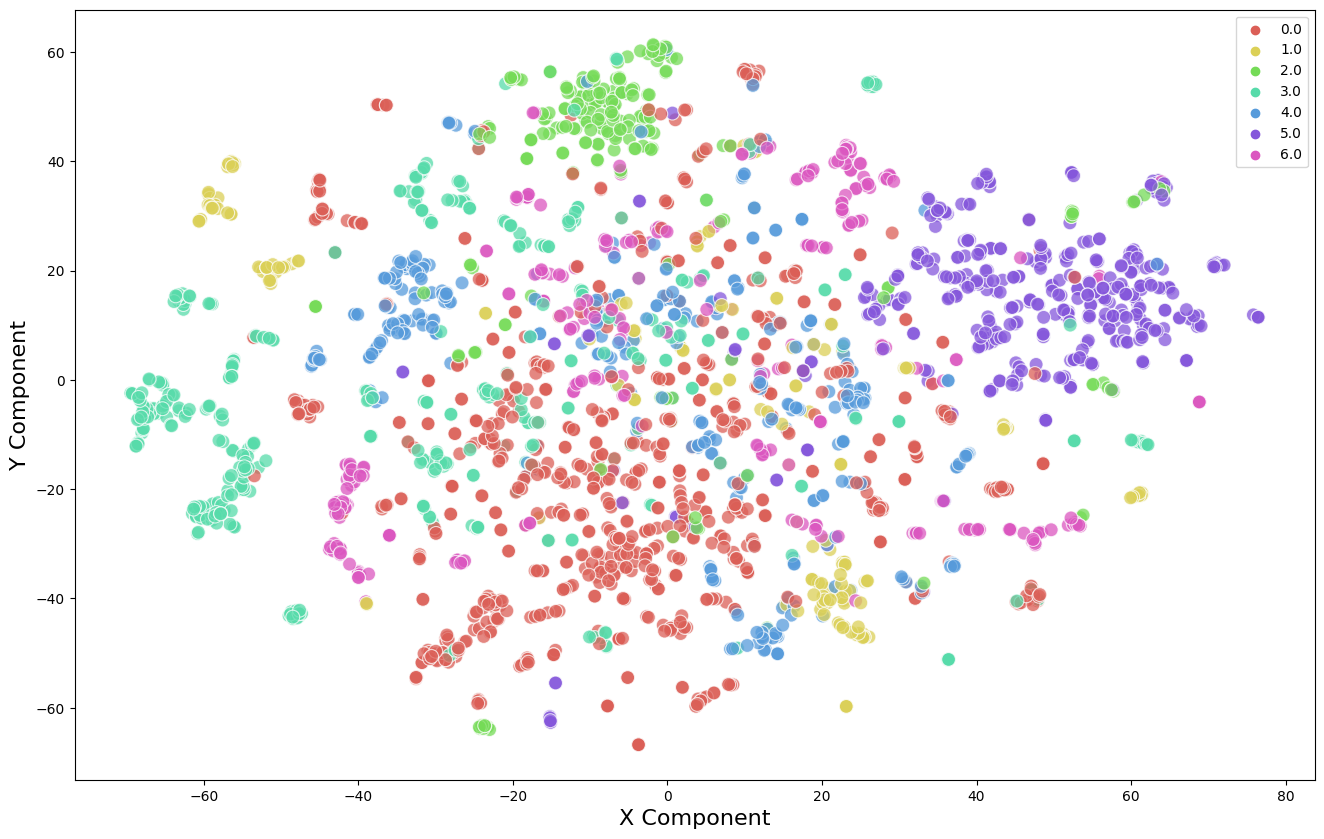

In [19]:
create_tsne_plot(df)

## Split Train & Test Data

In [20]:
encoder = LabelEncoder()
encoder.fit(df['class'])

df['class'] = encoder.transform(df['class'])


In [21]:
X = df[df.columns[2:-3]]  # Features
y = df['class']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

## Build Classifier

In [22]:
#Create a Gaussian Classifier
clf = XGBClassifier(n_estimators=100,
                    use_label_encoder=False,
                    eval_metric='mlogloss')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

## Classifier Metrics

In [23]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8216482164821648


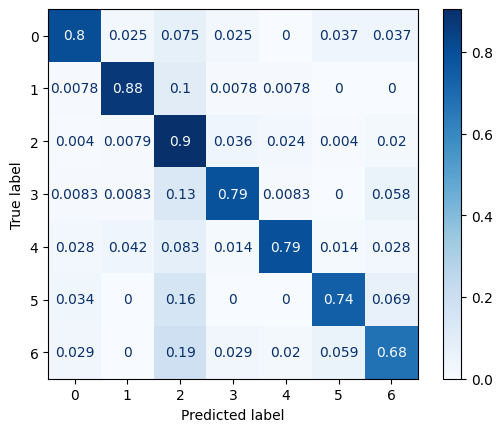

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, normalize='true')

<Axes: title={'center': 'Top 20 Feature Importances'}, xlabel='Feature', ylabel='Feature'>

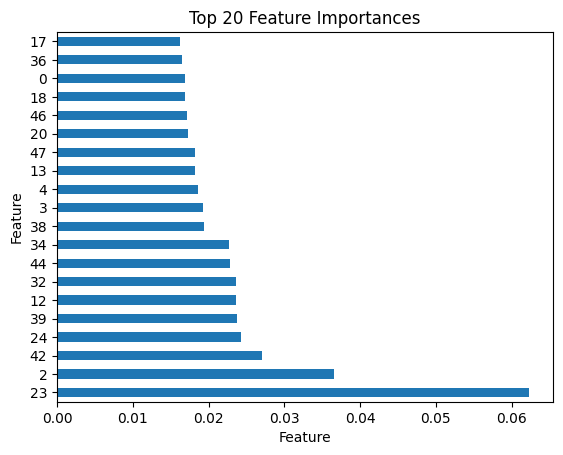

In [25]:
top_n = 20

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(top_n).plot(kind='barh', 
                                      title=f'Top {top_n} Feature Importances',
                                      xlabel= 'Feature',
                                      ylabel= 'Feature')